# Setup

In [1]:
# standard library imports
import time

# third party library imports
import numpy as np
import optuna
import pandas as pd

# machine learning imports
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    matthews_corrcoef,
    roc_auc_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    TargetEncoder,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# local imports
from utils import (
    plot_confusion_matrix,
    plot_correlation_heatmap,
    plot_feature_distributions,
    plot_model_metrics,
    plot_predictions,
    plot_probability_distribution,
    plot_target_correlations,
    validate_train_test_distribution,
)

In [2]:
# patch sklearn for performance boost
from sklearnex import patch_sklearn

patch_sklearn(verbose=False)

# EDA

In [3]:
# load data
index_col = "id"
train_data = pd.read_csv("train.csv", index_col=index_col)
test_data = pd.read_csv("test.csv", index_col=index_col)
sub_data = pd.read_csv("sample_submission.csv", index_col=index_col)

In [4]:
# preview data
train_data

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0


In [5]:
# check data types
train_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  str    
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  str    
 4   Gender           165034 non-null  str    
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), str(3)
memory usage: 16.4 MB


In [6]:
# check for missing values in each column
train_data.isna().sum().sort_values(ascending=False)

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
# check for unique values
train_data.nunique()

CustomerId         23221
Surname             2797
CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

In [8]:
# set target and classes
target = "Exited"
target_classes = ["0", "1"]
train_data[target].value_counts() * 100 / len(train_data)

Exited
0    78.84
1    21.16
Name: count, dtype: float64

In [9]:
# set features
numerical_features = [
    "Age",
    "Balance",
    "CreditScore",
    "EstimatedSalary",
]
nominal_features = [
    "Geography",
]
ordinal_features = [
    "Gender",
    "HasCrCard",
    "IsActiveMember",
    "NumOfProducts",
    "Tenure",
]
high_cardinality_features = [
    "CustomerId",
    "Surname",
]

categorical_features = nominal_features + ordinal_features
features = numerical_features + categorical_features + high_cardinality_features

plot_features = sorted(numerical_features + categorical_features)
corr_features = [target] + sorted(
    numerical_features + ordinal_features + high_cardinality_features
)

In [10]:
# use copies for exploratory analysis
train_data_encoded = train_data.copy()
test_data_encoded = test_data.copy()

# encode target (already encoded)
target_encoder = LabelEncoder().fit(train_data[target])
train_data_encoded[target] = np.asarray(target_encoder.transform(train_data[target]))

# encode categorical features
feature_encoders = {}
for feature in categorical_features:
    encoder = OrdinalEncoder().fit(train_data[[feature]])
    train_data_encoded[feature] = encoder.transform(train_data[[feature]])
    test_data_encoded[feature] = encoder.transform(test_data[[feature]])
    feature_encoders[feature] = encoder

# encode high cardinality features
for feature in high_cardinality_features:
    encoder = TargetEncoder()
    train_data_encoded[feature] = encoder.fit_transform(
        train_data[[feature]], train_data[target]
    )
    test_data_encoded[feature] = encoder.transform(test_data[[feature]])
    feature_encoders[feature] = encoder

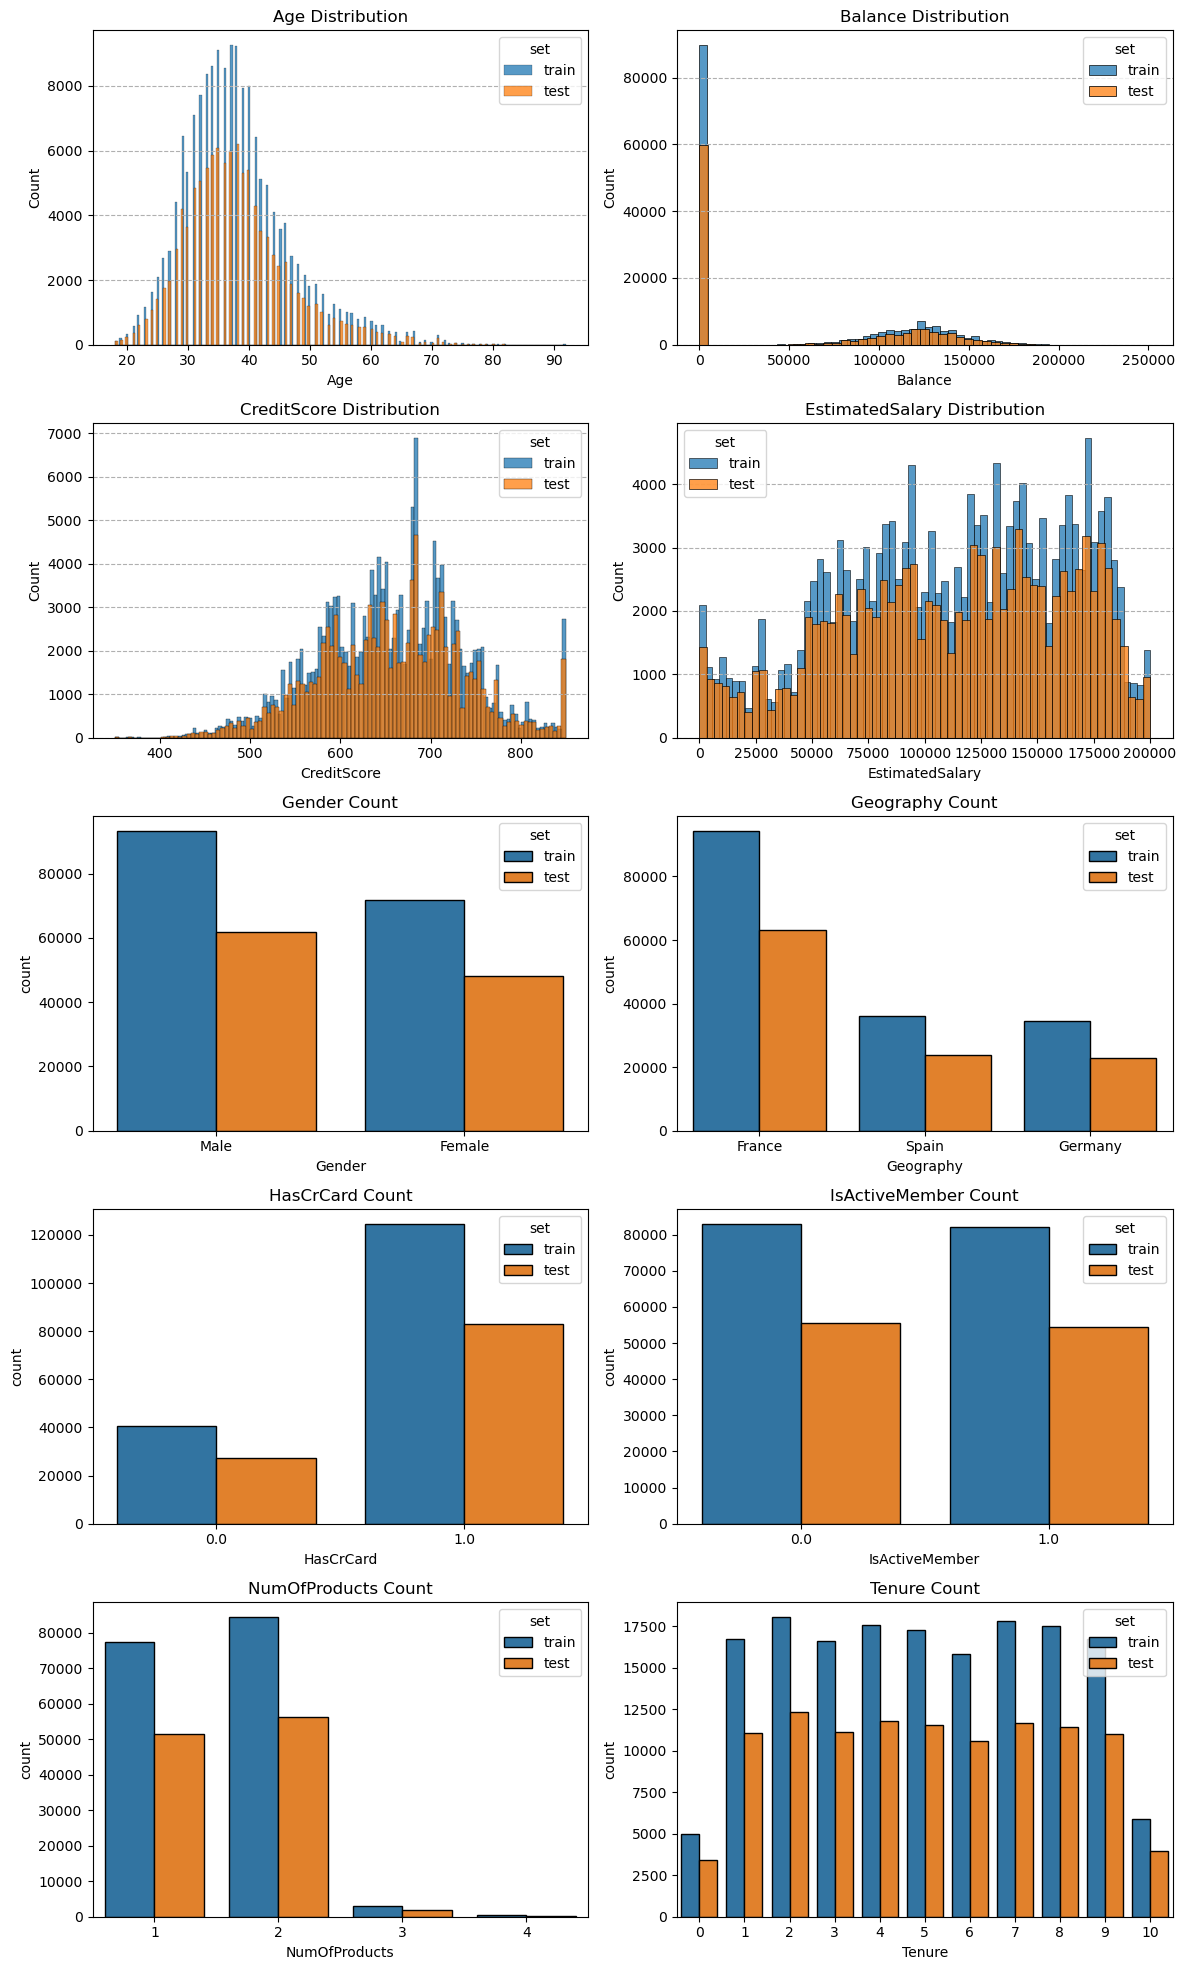

In [11]:
# plot features
plot_feature_distributions(
    train_data=train_data,
    test_data=test_data,
    features=plot_features,
    categorical_features=categorical_features,
)

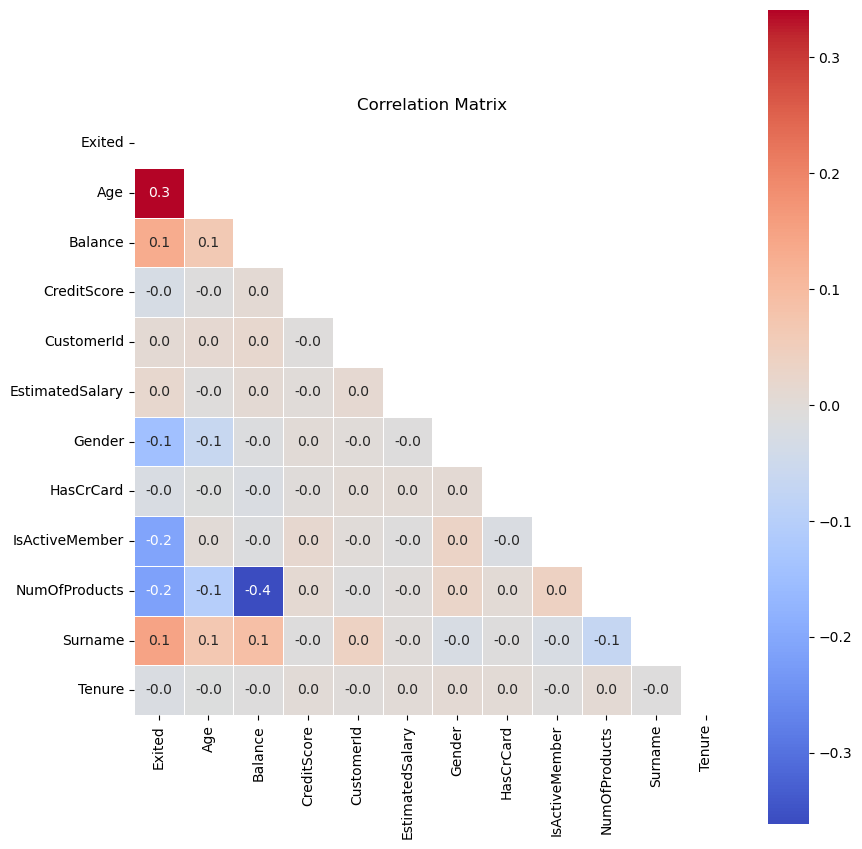

In [12]:
# plot correlations
plot_correlation_heatmap(train_data=train_data_encoded, features=corr_features)

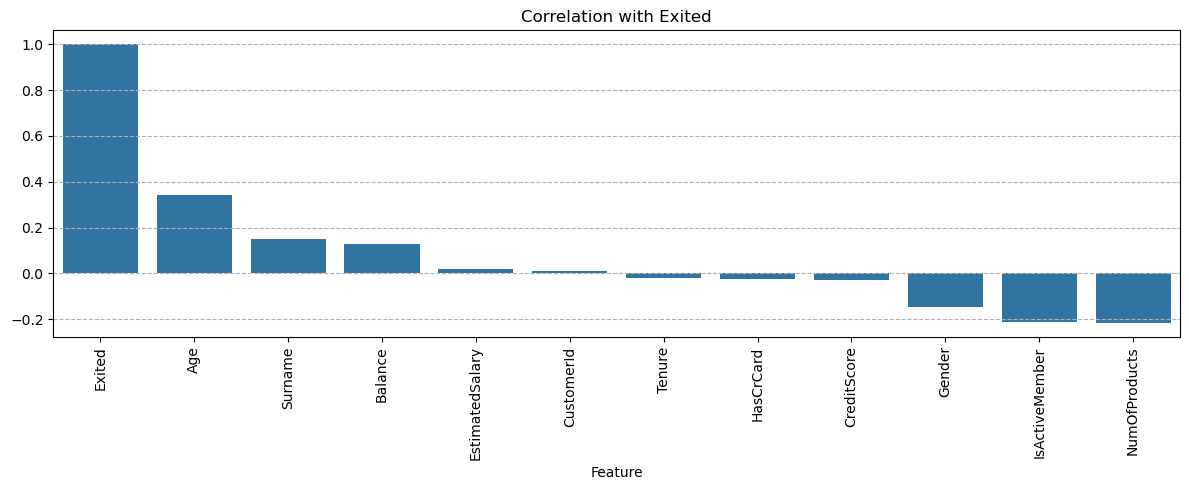

In [13]:
# plot target correlations
plot_target_correlations(
    train_data=train_data_encoded, target=target, features=corr_features
)

In [14]:
# validate that train and test sets have similar distributions
validate_train_test_distribution(
    train_data=train_data_encoded,
    test_data=test_data_encoded,
    features=plot_features,
    model=RandomForestClassifier(random_state=42, n_estimators=50),
    cv=5,
    threshold=0.6,
)

Validation score = 0.50 < threshold = 0.6 → train and test sets indistinguishable


# Data Preprocessing

In [15]:
# split data into training and test sets
X = train_data[features]
y = train_data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
# encode target
y_encoded = target_encoder.transform(y)
y_train_encoded = np.asarray(target_encoder.transform(y_train))
y_test_encoded = target_encoder.transform(y_test)

In [17]:
# define preprocessing columns and steps
transformer_config = {
    "numerical": {
        "columns": numerical_features,
        "steps": [("scale", RobustScaler())],
    },
    "nominal": {
        "columns": nominal_features,
        "steps": [
            (
                "encode",
                OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            )
        ],
    },
    "ordinal": {
        "columns": ordinal_features,
        "steps": [
            (
                "encode",
                OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            )
        ],
    },
    "high_cardinality": {
        "columns": high_cardinality_features,
        "steps": [("encode", TargetEncoder())],
    },
}


In [18]:
# build preprocessor
transformers = []
for feature_type, config in transformer_config.items():
    columns = config["columns"]
    steps = config["steps"]
    feature_pipeline = Pipeline(steps=steps)
    transformers.append((feature_type, feature_pipeline, columns))

preprocessor = ColumnTransformer(transformers=transformers)
preprocessor.set_output(transform="pandas")

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical', ...), ('nominal', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature

In [19]:
# define scoring metrics
metrics = {
    "accuracy": {
        "func": accuracy_score,
        "needs_proba": False,
    },
    "balanced_accuracy": {
        "func": balanced_accuracy_score,
        "needs_proba": False,
    },
    "f1_weighted": {
        "func": lambda y_true, y_pred: f1_score(y_true, y_pred, average="weighted"),
        "needs_proba": False,
    },
    "matthews_corrcoef": {
        "func": matthews_corrcoef,
        "needs_proba": False,
    },
    "neg_log_loss": {
        "func": lambda y_true, y_proba: -log_loss(y_true, y_proba),
        "needs_proba": True,
    },
    # binary
    "roc_auc": {
        "func": lambda y_true, y_proba: roc_auc_score(y_true, y_proba[:, 1]),
        "needs_proba": True,
    },
    # multiclass
    # "roc_auc": {
    #     "func": lambda y_true, y_proba: roc_auc_score(
    #         y_true, y_proba, multi_class="ovr", average="weighted"
    #     ),
    #     "needs_proba": True,
    # },
}

primary_metric = "roc_auc"

# Modelling

In [20]:
models = {
    "lr": {
        "model": LogisticRegression(random_state=42, max_iter=10000),
        "params": {
            "lr__C": ("float", 1e-3, 1e3, {"log": True}),
            "lr__solver": ("categorical", ["liblinear", "lbfgs"], None, {}),
        },
    },
    # too slow
    # "svc": {
    #     "model": SVC(probability=True),
    #     "params": { ... },
    # },
    "rf": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "rf__n_estimators": ("int", 50, 500, {}),
            "rf__max_depth": ("int", 3, 20, {}),
            "rf__min_samples_split": ("int", 2, 20, {}),
            "rf__min_samples_leaf": ("int", 1, 10, {}),
            "rf__max_features": ("categorical", ["sqrt", "log2"], None, {}),
        },
    },
    "decision": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "decision__max_depth": ("int", 3, 20, {}),
            "decision__min_samples_split": ("int", 2, 20, {}),
            "decision__min_samples_leaf": ("int", 1, 10, {}),
            "decision__criterion": ("categorical", ["gini", "entropy"], None, {}),
        },
    },
    "xgb": {
        "model": XGBClassifier(random_state=42),
        "params": {
            "xgb__n_estimators": ("int", 100, 1000, {}),
            "xgb__max_depth": ("int", 3, 10, {}),
            "xgb__learning_rate": ("float", 1e-3, 0.3, {"log": True}),
            "xgb__subsample": ("float", 0.5, 1.0, {}),
            "xgb__colsample_bytree": ("float", 0.5, 1.0, {}),
            "xgb__min_child_weight": ("int", 1, 10, {}),
            "xgb__gamma": ("float", 1e-8, 1.0, {"log": True}),
        },
    },
    "lgb": {
        "model": LGBMClassifier(random_state=42, verbose=-1),
        "params": {
            "lgb__n_estimators": ("int", 100, 1000, {}),
            "lgb__num_leaves": ("int", 31, 128, {}),
            "lgb__learning_rate": ("float", 1e-3, 0.3, {"log": True}),
            "lgb__subsample": ("float", 0.5, 1.0, {}),
            "lgb__colsample_bytree": ("float", 0.5, 1.0, {}),
            "lgb__min_child_samples": ("int", 20, 200, {}),
            "lgb__reg_alpha": ("float", 1e-8, 10.0, {"log": True}),
            "lgb__reg_lambda": ("float", 1e-8, 10.0, {"log": True}),
        },
    },
    "gb": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "gb__n_estimators": ("int", 50, 500, {}),
            "gb__learning_rate": ("float", 1e-3, 0.3, {"log": True}),
            "gb__max_depth": ("int", 3, 10, {}),
            "gb__subsample": ("float", 0.5, 1.0, {}),
            "gb__min_samples_split": ("int", 2, 20, {}),
            "gb__min_samples_leaf": ("int", 1, 10, {}),
        },
    },
    "ada": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "ada__n_estimators": ("int", 50, 500, {}),
            "ada__learning_rate": ("float", 1e-3, 1.0, {"log": True}),
        },
    },
    "cat": {
        "model": CatBoostClassifier(
            random_state=42,
            verbose=0,
            bootstrap_type="Bernoulli",
            allow_writing_files=False,
        ),
        "params": {
            "cat__iterations": ("int", 100, 1000, {}),
            "cat__depth": ("int", 3, 10, {}),
            "cat__learning_rate": ("float", 1e-3, 0.3, {"log": True}),
            "cat__l2_leaf_reg": ("float", 1e-8, 10.0, {"log": True}),
            "cat__subsample": ("float", 0.5, 1.0, {}),
        },
    },
}

In [21]:
# train all models with default parameters on X_train
train_results_list = []
train_times = {}
pipelines = {}

cv_train = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model_config in models.items():
    pipeline = Pipeline(
        [
            ("preprocessor", preprocessor),
            (model_name, model_config["model"]),
        ]
    )

    start_time = time.time()
    search = GridSearchCV(
        estimator=pipeline,
        param_grid={},
        cv=cv_train,
        scoring=primary_metric,
        refit=True,
    )
    search.fit(X_train, y_train_encoded)
    elapsed_time = time.time() - start_time

    cv_scores = {primary_metric: search.cv_results_["mean_test_score"][0]}
    cv_scores["model"] = model_name

    pipelines[model_name] = search.best_estimator_
    train_times[model_name] = elapsed_time
    train_results_list.append(cv_scores)

train_results = pd.DataFrame(train_results_list).set_index("model")
train_results = train_results.sort_values(primary_metric, ascending=False)
display(train_results)

,roc_auc
model,
lgb,0.892
cat,0.892
gb,0.891
xgb,0.888
rf,0.883
ada,0.875
lr,0.823
decision,0.706


In [22]:
# tune best model on X_train
best_model_name = str(train_results[primary_metric].idxmax())

cv_search = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


def objective(trial):
    param_space = models[best_model_name]["params"]
    params = {}
    for param_name, spec in param_space.items():
        suggest_type, low, high, kwargs = spec
        if suggest_type == "int":
            params[param_name] = trial.suggest_int(param_name, low, high, **kwargs)
        elif suggest_type == "float":
            params[param_name] = trial.suggest_float(param_name, low, high, **kwargs)
        elif suggest_type == "categorical":
            params[param_name] = trial.suggest_categorical(param_name, low)

    trial_pipeline = clone(pipelines[best_model_name])
    trial_pipeline.set_params(**params)

    scores = []
    for train_idx, val_idx in cv_search.split(X_train, y_train_encoded):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train_encoded[train_idx], y_train_encoded[val_idx]
        trial_pipeline.fit(X_fold_train, y_fold_train)
        y_fold_pred = trial_pipeline.predict(X_fold_val)
        scores.append(accuracy_score(y_fold_val, y_fold_pred))

    return sum(scores) / len(scores)


tuned_start_time = time.time()

study = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

tuned_elapsed_time = time.time() - tuned_start_time

tuned_model_name = f"{best_model_name}_tuned"
tuned_params = study.best_params

tuned_pipeline = clone(pipelines[best_model_name])
tuned_pipeline.set_params(**tuned_params)
tuned_pipeline.fit(X_train, y_train_encoded)

pipelines[tuned_model_name] = tuned_pipeline
train_times[tuned_model_name] = tuned_elapsed_time

train_results.loc[tuned_model_name] = {primary_metric: study.best_value}
train_results = train_results.sort_values(primary_metric, ascending=False)

display(tuned_params)

Best trial: 34. Best value: 0.86752: 100%|██████████| 50/50 [18:34<00:00, 22.30s/it] 


{'lgb__n_estimators': 592,
 'lgb__num_leaves': 38,
 'lgb__learning_rate': 0.013053700342513292,
 'lgb__subsample': 0.6183640330639895,
 'lgb__colsample_bytree': 0.8107371168752001,
 'lgb__min_child_samples': 60,
 'lgb__reg_alpha': 0.28313991473226996,
 'lgb__reg_lambda': 1.6350139435978244e-07}

In [23]:
# evaluate all models on X_test
test_results_list = []
confusion_matrices = {}

for model_name, pipeline in pipelines.items():
    y_test_pred = pipeline.predict(X_test)
    y_test_pred_proba = pipeline.predict_proba(X_test)

    test_scores = {}
    for metric_name, metric_config in metrics.items():
        if metric_config["needs_proba"]:
            test_scores[metric_name] = metric_config["func"](
                y_test_encoded, y_test_pred_proba
            )
        else:
            test_scores[metric_name] = metric_config["func"](
                y_test_encoded, y_test_pred
            )

    test_scores["model"] = model_name
    test_results_list.append(test_scores)

    confusion_matrices[model_name] = confusion_matrix(y_test_encoded, y_test_pred)

test_results = pd.DataFrame(test_results_list).set_index("model")
test_results["train_time"] = pd.Series(train_times)
test_results = test_results.sort_values(primary_metric, ascending=False)

display(test_results)

,accuracy,balanced_accuracy,f1_weighted,matthews_corrcoef,neg_log_loss,roc_auc,train_time
model,,,,,,,
lgb_tuned,0.870,0.760,0.863,0.579,-0.312,0.896,1114.802
lgb,0.870,0.763,0.863,0.580,-0.312,0.895,3.302
cat,0.869,0.758,0.862,0.575,-0.311,0.895,56.611
gb,0.868,0.752,0.860,0.569,-0.315,0.894,83.703
xgb,0.868,0.762,0.862,0.575,-0.316,0.892,8.193
rf,0.865,0.748,0.857,0.559,-0.357,0.886,114.779
ada,0.859,0.730,0.848,0.533,-0.512,0.877,15.339
lr,0.837,0.678,0.820,0.444,-0.389,0.825,14.499
decision,0.799,0.706,0.801,0.405,-7.243,0.706,7.137


In [24]:
# retrain tuned model on X_train and X_test
final_model = clone(tuned_pipeline)
final_model.fit(X, y_encoded)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('lgb', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical', ...), ('nominal', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different tr

# Results

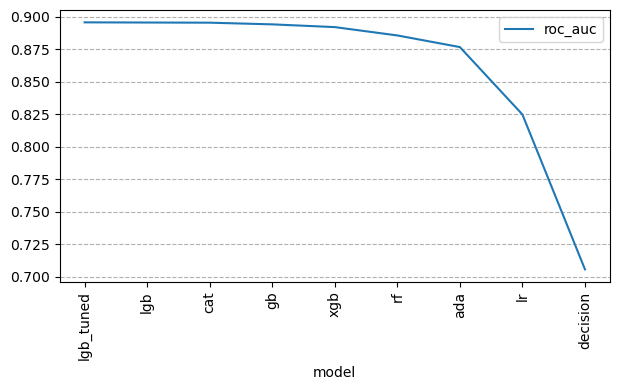

In [25]:
# plot initial results
plot_model_metrics(test_results, primary_metric)

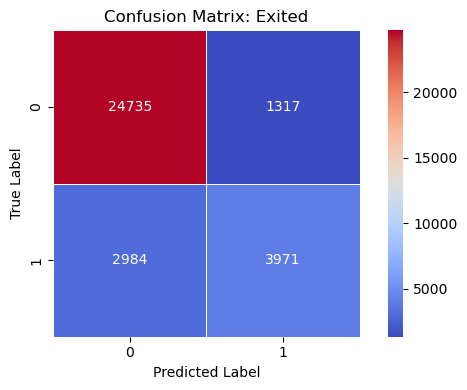

In [26]:
# plot confusion matrix
plot_confusion_matrix(
    cm=confusion_matrices[tuned_model_name],
    target=target,
    class_labels=target_classes,
)

In [27]:
# make predictions and probabilties
test_pred = final_model.predict(test_data)
test_pred_proba = final_model.predict_proba(test_data)[:, 1]
decoded_pred = target_encoder.inverse_transform(test_pred)

# write to submissions file
sub_data[target] = test_pred_proba
sub_data.to_csv("submission.csv", index=True, index_label=index_col)
pd.read_csv("submission.csv")

,id,Exited
0,165034,0.019
1,165035,0.842
2,165036,0.028
3,165037,0.213
4,165038,0.380
...,...,...
110018,275052,0.036
110019,275053,0.108
110020,275054,0.021
110021,275055,0.173


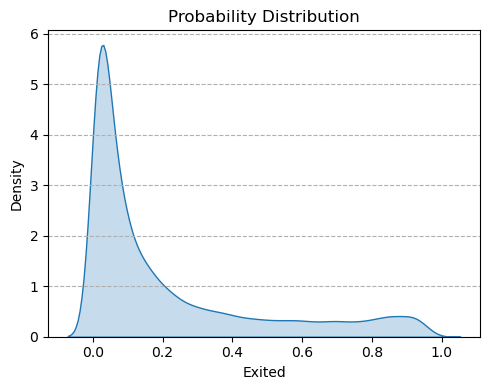

In [28]:
# plot probabilities
plot_probability_distribution(sub_data[target], target=target)